# Add Folders to Path

In [1]:
%%time
import sys, os
# get current directory
path = os.getcwd()
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])
# add Algorithm folder to current working path in order to access the functions inside the folder ´Algorithms´
sys.path.append(parent_directory+"/Src")

Wall time: 0 ns


# DEMO AGULHAS ELLIPTIC OECS

## Import data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../Data/Agulhas_AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time = mat_file['t']

Wall time: 140 ms


## Data/Parameters for dynamical system

In [3]:
%%time
import numpy as np

# Number of cores to be used for parallel computing
Ncores = 4

# Incompressible/Compressible flow. {True, False}
Incompressible = True

# Periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## Compute Meshgrid
X, Y = np.meshgrid(x, y)

# List of parameters of the flow.
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, 
               "Incompressible": Incompressible, "Periodic": Periodic}

Wall time: 0 ns


<a id='Spatio-Temporal-Domain-of-Dynamical-System'></a>
## Spatio-temporal domain of dynamical system

In [4]:
%%time
# time (in days)
t = 0

time = [t]

# longitudinal and latitudinal boundaries (in degrees)
xmin = 0
xmax = 7
ymin = -38
ymax = -30

# spacing of meshgrid (in degrees)
dx = 0.01
dy = 0.01

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

Wall time: 2 ms


In [5]:
%%time
# Initialize Dynamical System
from ipynb.fs.defs.DynamicalSystem import *
DS = Dynamical_System(params_data, params_DS)

Wall time: 413 ms


## Velocity interpolation

In [6]:
%%time
# Interpolate velocity data using cubic spatial interpolation
DS._Interpolation_velocity("cubic")

Wall time: 108 ms


## Compute rate of strain tensor $ S(\mathbf{x},t) $ over meshgrid

The rate of strain tensor $ S(\mathbf{x}, t) $ at time $ t $ is computed by iterating over meshgrid. The method *DS._spin_tensor(x, t)* computes the rate of strain tensor at point $ \mathbf{x} $  at time $ t $ by using an auxiliary meshgrid. 

In [7]:
%%time
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid = 0.05

def parallel(i):
    
    S_ = np.zeros((X_domain.shape[1], 2, 2))
    
    for j in range(S_.shape[0]):
        
        x = np.array([X_domain[i,j], Y_domain[i,j]])
        
        S_[j, :, :] = DS._spin_tensor(x, time, aux_grid)
    
    return S_

S = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/802 [00:00<?, ?it/s]

Wall time: 1min 48s


## Identify vortex centers from local maximum of instantaneous IVD

Centers of elliptic OECS are given by local maxima in the IVD field.

In [8]:
%%time
from ipynb.fs.defs.loc_max import _loc_max

sys.path.append(parent_directory+"/Demos/IVD")
from ipynb.fs.defs.IVD import _IVD

IVD = _IVD(X_domain, Y_domain, DS, time, aux_grid)

# distance between local maxima
max_distance = .25

# threshold on local maximum of IVD
loc_threshold = 1.4

x_vortex, y_vortex = _loc_max(max_distance, X_domain, Y_domain, IVD, loc_threshold)[2:4]

  0%|          | 0/802 [00:00<?, ?it/s]

Wall time: 5min 11s


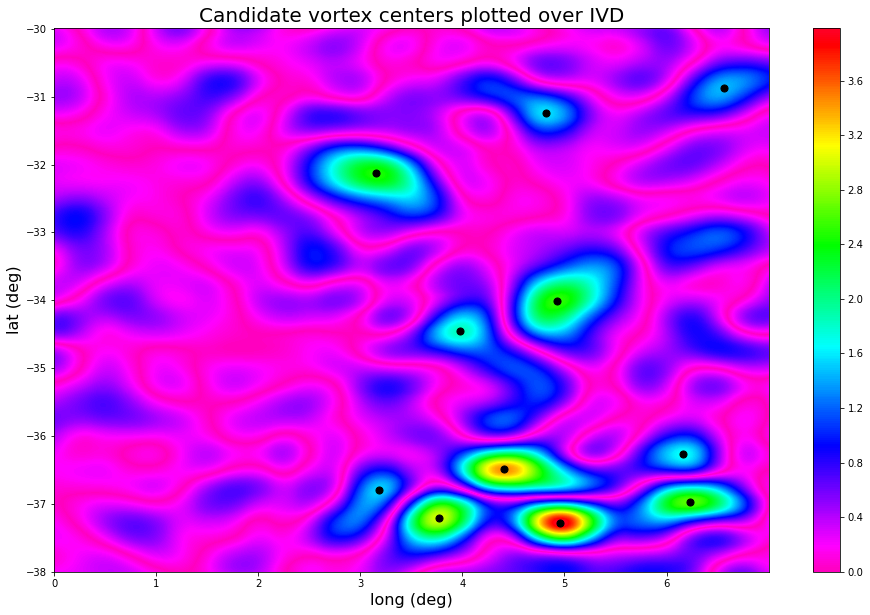

In [9]:
###################################### PLOT VORTEX CENTERS FROM IVD ######################################
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16, 10))
ax = plt.axes()

cax = ax.contourf(X_domain, Y_domain, IVD, levels=600, cmap='gist_rainbow_r')
ax.scatter(x_vortex, y_vortex, s = 50, c = 'k', label='Vortex center')

ax.set_xlabel('long (deg)', fontsize = 16)
ax.set_ylabel('lat (deg)', fontsize = 16)

ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), 1))

ax.set_title('Candidate vortex centers plotted over IVD', fontsize = 20)

cbar = plt.colorbar(cax)
plt.show()

## Shearlines (Elliptic OECS)

Elliptic LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0(s) = \sqrt{\dfrac{s_2-\mu}{s_2-s_1}}\xi_2(\mathbf{x}_0;t_0, t_N) \pm\sqrt{\dfrac{s_1-\mu}{s_2-s_1}}\xi_1(\mathbf{x}_0;t_0, t_N),
\label{eq: shearlines}
\end{equation}

with $ \xi_1, \xi_2 $ denoting the eigenvector associated to the weakest/strongest eigenvalue $ \lambda_1/\lambda_2 $ of $ C_{t_0}^{t_N}(\mathbf{x}_0) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ \lambda_1 = \lambda_2 $).
The outermost closed shearline mark initial positions of elliptic LCS at time $ t_0 $. The integration of the autonomous system in eq. \ref{eq: shearlines} is done with respect to the non-dimensional parameter $ s $.

In [ ]:
%%time
from ipynb.fs.defs.shearlines import _shearlines
from ipynb.fs.defs.outermost_closed_shearline import _outermost_closed_shearline

from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# step-size used for integration with respect to parameter 's'
step_size = 1

# range of mu values
mu_range = np.arange(-0.03, 0.04, 0.01)

# length Poincare-section 
len_poincare = 2

# threshold distance for re-intersection of closed shearline with poincare section
d_threshold = 0.05

# threshold length of vortex
length_threshold = 2*np.pi*len_poincare*2

# define elliptic LCS
elliptic_OECS = [[], []] # list storing elliptic LCS
mu_elliptic_OECS = [] # list storing corresponding mu to elliptic LCS

def parallel(i):
    
    for mu in mu_range:
        
        # integrate lambda line for eta_pos and eta_neg
        for sign_eta in [-1, 1]:

            shearlines, distance_ps_s, vector_field = _shearlines(X_domain, Y_domain, S, mu, x_vortex[i], y_vortex[i], len_poincare, length_threshold, step_size, sign_eta)
            
            elliptic_OECS_x, elliptic_OECS_y = _outermost_closed_shearline(X_domain, Y_domain, S, mu, sign_eta, shearlines, distance_ps_s, x_vortex[i], y_vortex[i], d_threshold, length_threshold, step_size)
            
            if elliptic_OECS_x is not None:
                elliptic_OECS[0].append(elliptic_OECS_x)
                elliptic_OECS[1].append(elliptic_OECS_y)
                mu_elliptic_OECS.append(mu)
                break
                
    return elliptic_OECS, mu_elliptic_OECS

res = Parallel(n_jobs=DS.Ncores, verbose = 0)(delayed(parallel)(i) for i in tqdm(range(len(x_vortex))))

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
###################################### PLOT ELLIPTIC LCS ######################################

fig = plt.figure(figsize = (16, 10))
ax = plt.axes()

for i in range(len(elliptic_OECS[0])):
    ax.plot(elliptic_OECS[0][i], elliptic_OECS[1][i])

ax.set_xlabel('long (deg)', fontsize = 16)
ax.set_ylabel('lat (deg)', fontsize = 16)

ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), 1))

ax.set_title('Elliptic OECSs from closed shearlines', fontsize = 20)

plt.show()